# Adding average uniqueness and weights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

In [14]:
# events = pd.read_csv("../data/events.csv", index_col=0, parse_dates=[0, 1])
t1 = pd.to_datetime(pd.read_csv("../data/t1.csv", index_col=0, parse_dates=True, squeeze=True))
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)

In [15]:
def mp_num_co_events(close_idx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(close_idx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=close_idx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=close_idx[iloc[0]:iloc[1]+1])
    for t_in,t_out in t1.iteritems():
        count.loc[t_in:t_out]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

In [16]:
num_co_events = mp_pandas_obj(mp_num_co_events,('molecule',t1.index),                         
                              1,close_idx=df.index,t1=t1)

In [17]:
num_co_events

2021-04-23 10:40:59.703    1.0
2021-04-23 10:41:01.152    1.0
2021-04-23 10:41:02.610    1.0
2021-04-23 10:41:04.496    1.0
2021-04-23 10:41:05.343    1.0
                          ... 
2021-06-19 16:27:04.502    7.0
2021-06-19 16:27:20.667    7.0
2021-06-19 16:27:26.627    7.0
2021-06-19 16:27:44.405    7.0
2021-06-19 16:27:48.270    7.0
Length: 995013, dtype: float64

## Get average uniqueness of a label

In [18]:
def mp_sample_tw(t1,num_co_events,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule, dtype=float)
    for t_in,t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in]=(1./num_co_events.loc[t_in:t_out]).mean()
    return wght

In [19]:
out=pd.DataFrame()
out['au'] = mp_pandas_obj(mp_sample_tw,('molecule',t1.index),
                            1,t1=t1,num_co_events=num_co_events)
out

,au
2021-04-23 10:40:59.703,0.356069
2021-04-23 11:37:55.961,0.311475
2021-04-23 13:43:05.131,0.285620
2021-04-23 20:03:08.333,0.318221
2021-04-24 11:00:19.121,0.694965
...,...
2021-06-18 18:39:29.436,0.137594
2021-06-18 18:54:17.615,0.136496
2021-06-19 03:03:38.429,0.127169
2021-06-19 03:29:01.660,0.126442


## Determination of sample weight by absolute return attribution

In [20]:
def mp_sample_w(t1,num_co_events,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule, dtype=float)
    for t_in,t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in]=(ret.loc[t_in:t_out]/num_co_events.loc[t_in:t_out]).sum()
    return wght.abs()

In [21]:
## example ##
out['w']=mp_pandas_obj(mp_sample_w,('molecule',t1.index),1,
                         t1=t1,num_co_events=num_co_events,close=df.close)
out['w']*=out.shape[0]/out['w'].sum()

out

,au,w
2021-04-23 10:40:59.703,0.356069,0.361899
2021-04-23 11:37:55.961,0.311475,0.989108
2021-04-23 13:43:05.131,0.285620,1.051907
2021-04-23 20:03:08.333,0.318221,0.420450
2021-04-24 11:00:19.121,0.694965,1.534189
...,...,...
2021-06-18 18:39:29.436,0.137594,0.126692
2021-06-18 18:54:17.615,0.136496,0.266729
2021-06-19 03:03:38.429,0.127169,0.194361
2021-06-19 03:29:01.660,0.126442,0.363243


## Time decay

In [22]:
def get_time_decay(au,clf_last_w=1.,exponent=1):
    # apply optional exponential time decay to observed uniqueness (au)
    # newest observation gets weight=1, oldest observation gets weight=clf_last_w
    clf_w=au.sort_index().cumsum()
    if clf_last_w>=0: slope=((1.-clf_last_w)/clf_w.iloc[-1])**exponent
    else: slope=(1./((clf_last_w+1)*clf_w.iloc[-1]))**exponent
    const=1.-slope*clf_w.iloc[-1]
    clf_w=const+slope*clf_w
    clf_w[clf_w<0]=0
    print(round(const,4), round(slope,4))
    return clf_w

In [23]:
out['decay'] = get_time_decay(out['au'].dropna(), clf_last_w=.5, exponent=1)

0.5 0.009


In [24]:
out['wd'] = out.w*out.decay

In [25]:
out

,au,w,decay,wd
2021-04-23 10:40:59.703,0.356069,0.361899,0.503201,0.182108
2021-04-23 11:37:55.961,0.311475,0.989108,0.506002,0.500490
2021-04-23 13:43:05.131,0.285620,1.051907,0.508570,0.534968
2021-04-23 20:03:08.333,0.318221,0.420450,0.511431,0.215031
2021-04-24 11:00:19.121,0.694965,1.534189,0.517679,0.794217
...,...,...,...,...
2021-06-18 18:39:29.436,0.137594,0.126692,0.995331,0.126100
2021-06-18 18:54:17.615,0.136496,0.266729,0.996558,0.265811
2021-06-19 03:03:38.429,0.127169,0.194361,0.997702,0.193914
2021-06-19 03:29:01.660,0.126442,0.363243,0.998838,0.362821


In [108]:
out.to_csv("../data/weighted_t1.csv")

## Plotting

Text(0.5, 1.0, 'Weight, Time decay, and Weighted time decay')

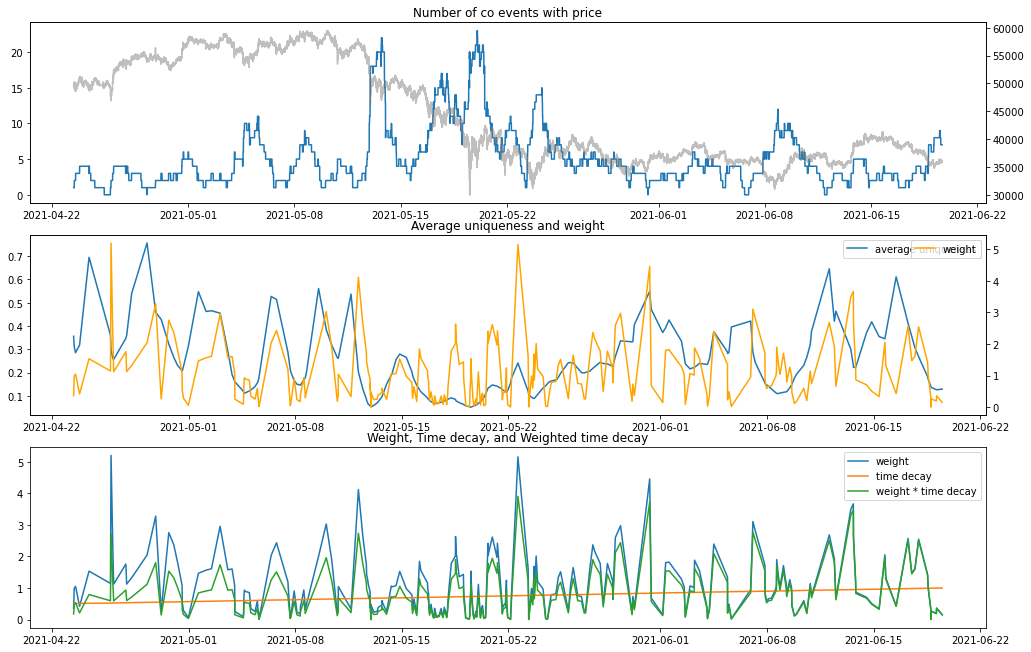

In [26]:
fig, [ax, ax1, ax3] = plt.subplots(3, figsize=(14, 9))
fig.tight_layout()

ax.plot(num_co_events)
ax.set_title("Number of co events with price")
ax0 = ax.twinx()
ax0.plot(df.reindex(num_co_events.index).close, color="gray", alpha=.5)

ax1.plot(out.au, label="average uniqueness")
ax1.set_title("Average uniqueness and weight")

ax2 = ax1.twinx()
ax2.plot(out.w, label="weight", color='orange')
ax1.legend()
ax2.legend()

ax3.plot(out.w, label="weight")
ax3.plot(out.decay, label = "time decay")
ax3.plot(out.wd, label = "weight * time decay")
ax3.legend()
ax3.set_title("Weight, Time decay, and Weighted time decay")